In [39]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs


In [40]:
df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Nepal Master Sheet.xlsx', sheet_name='Final_compiled')

df_copy = df.copy()

In [41]:
df_copy = df_copy[df_copy['Sample type'] == 'Spring water']    

In [42]:
df_copy['Ca_mM'] = df_copy['Ca_ppm'] / 40.08
df_copy['Sr_mM'] = df_copy['Sr_ppm'] / 87.62
df_copy['Mg_mM'] = df_copy['Mg_ppm'] / 24.31
df_copy['Si_mM'] = df_copy['Si_ppm'] / 28.09
df_copy['Na_mM'] = df_copy['Na_ppm'] / 22.99

df_copy['Ca/Na'] = df_copy['Ca_mM'] / df_copy['Na_mM']
df_copy['Na/Ca'] = df_copy['Na_mM'] / df_copy['Ca_mM']


df_copy['Mg/Ca'] = df_copy['Mg_mM'] / df_copy['Ca_mM']
df_copy['Mg/Na'] = df_copy['Mg_mM'] / df_copy['Na_mM']
df_copy['Ca/Sr'] = df_copy['Ca_mM'] / df_copy['Sr_mM']
df_copy['1000xSr/Ca'] = df_copy['Sr_mM'] / df_copy['Ca_mM'] * 1000

df_copy['Si/Ca'] = df_copy['Si_mM'] / df_copy['Ca_mM']
df_copy['Na/Ca'] = df_copy['Na_mM'] / df_copy['Ca_mM']

# δ87Sr = [(87Sr/86Srsample/87Sr/86Srmsw)-1]×1000,

# 87Sr/86Srmsw is the value for modern sea water (msw) of 0.70920

df_copy['Delta87Sr'] = ((df_copy['Sr87/Sr86'] / 0.70920) - 1) * 1000

In [43]:
## ADDING DEM DATA TO THE PLOT
    
dem_path = '/Users/enrico/Desktop/Part III Project/DEM/AP_23217_PLR_F0550_RT1/AP_23217_PLR_F0550_RT1.dem.tif'

    
# Define UTM bounds for Nepal DEM
min_x, min_y, max_x, max_y = 346873.46875, 3078339.0, 362335.96875, 3115539.0


# Define UTM bounds for Nepal DEM
# Set CRS WKT strings
utm_45n_wkt = 'PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",' \
            'SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],' \
            'AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],' \
            'UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],' \
            'PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],' \
            'PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],' \
            'PARAMETER["false_easting",500000],PARAMETER["false_northing",0],' \
            'UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32645"]]'

wgs84_wkt = 'GEOGCS["WGS 84",DATUM["WGS_1984",' \
            'SPHEROID["WGS 84",6378137,298.257223563],' \
            'AUTHORITY["EPSG","6326"]],' \
            'PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],' \
            'AUTHORITY["EPSG","4326"]]'

In [44]:
# Open the DEM file and set CRS to UTM Zone 45N if undefined
with rasterio.open(dem_path) as dem_raster:
    src_crs = rasterio.crs.CRS.from_wkt(utm_45n_wkt)  # Using WKT for UTM Zone 45N
    dst_crs = rasterio.crs.CRS.from_wkt(wgs84_wkt)    # Using WKT for WGS84

    # Create a Shapely box with UTM bounds
    dem_box = box(min_x, min_y, max_x, max_y)

    # Mask DEM data to these bounds
    out_image, out_transform = mask(dem_raster, [dem_box], crop=True)
    clipped_dem_array = out_image[0]

    # Calculate transform and reproject to WGS84
    dst_transform, width, height = calculate_default_transform(
        src_crs, dst_crs, clipped_dem_array.shape[1], clipped_dem_array.shape[0], *[min_x, min_y, max_x, max_y]
    )

    dst_array = np.zeros((height, width), dtype=np.float32)
    reproject(
        source=clipped_dem_array,
        destination=dst_array,
        src_transform=out_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear
    )

    dst_array[dst_array < 0] = np.nan  # Filter out elevation values below 0

# Define bounds in WGS84 (latitude/longitude) for plotting
bounds = (
    dst_transform.c,  # min longitude
    dst_transform.f + dst_transform.e * height,  # min latitude
    dst_transform.c + dst_transform.a * width,  # max longitude
    dst_transform.f  # max latitude
)


In [45]:
# Generate the x and y coordinates in WGS84
x = np.linspace(bounds[0], bounds[2], dst_array.shape[1])
y = np.linspace(bounds[1], bounds[3], dst_array.shape[0])
x, y = np.meshgrid(x, y)
z = dst_array

# Interpolator for DEM elevations
interpolator = RegularGridInterpolator((y[:, 0], x[0, :]), z, bounds_error=False, fill_value=np.nan)

# Ensure the DataFrame coordinates are in the same CRS as the DEM
df_lons = df_copy['Longitude'].values
df_lats = df_copy['Latitude'].values

# Load the shapefile
shapefile_path1 = "/Users/enrico/Desktop/Part III Project/DEM/Clipped_Shp_Melamchi.shp"
gdf = gpd.read_file(shapefile_path1)



In [46]:
######### IMPORTING DATA FOR GEOLOGY OVERLAY #########

# Load the shapefile
shapefile_path2 = "/Users/enrico/Desktop/Part III Project/QGIS during Fieldwork/geometry5.shp"
gdf2 = gpd.read_file(shapefile_path2)

    

In [47]:
#For Shapefile
    # Define color mapping based on ID
id_to_color = {
    0: 'Blue',
    1: 'Green',
    2: 'Yellow',
    3: 'Orange',
    5: 'Purple',
    }

id_to_label = {
    0: 'Talamarang Formation',
    1: 'Gyalthum Formation',
    2: 'Bolde Quartzite',
    3: 'Timbung Formation',
    5: 'Golphu Formation',
    }

In [80]:
season_colors = {
    'Nov_22': 'blue',
    'Apr_23': 'green',
    'Oct_23': 'red',
    'Sep_24': 'purple'
}

traverse_markers = {
    'Traverse 1': 's',  # Square
    'Traverse 2': 'v',  # Triangle
    'Traverse 3': '*',  # Star
    'Traverse 4': 'o'   # Circle
}

GNS_markers = {
    'S1': 'o',  
    'S2': 'o',  
    'S3': 'o',  
    'S4': 'o'   
}





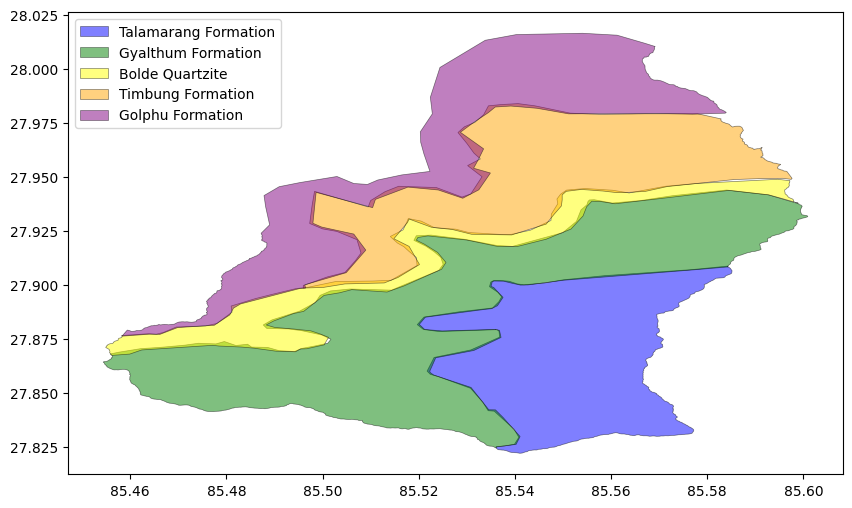

In [49]:
# Define the desired CRS, for example, "EPSG:4326" for WGS 84 or any other projection you need.
desired_crs = "EPSG:4326"

# Reproject the GeoDataFrame to the desired CRS
gdf2 = gdf2.to_crs(desired_crs)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the overlay shapefile with specified colors and labels
plotted_labels = set()  # Keeps track of which labels have been plotted
for geom, id_value in zip(gdf2.geometry, gdf2['id']):
    color = id_to_color.get(id_value, 'grey')  # Default to grey if ID is not in the mapping
    label = id_to_label.get(id_value, '')
    
    if isinstance(geom, Polygon):  # Check if geometry is a Polygon
        x_poly, y_poly = geom.exterior.xy  # Get exterior coordinates
        if label not in plotted_labels:
            ax.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5, label=label)
            plotted_labels.add(label)
        else:
            ax.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)
    
    elif isinstance(geom, MultiPolygon):  # Check if geometry is a MultiPolygon
        for part in geom.geoms:  # Iterate over constituent polygons
            x_poly, y_poly = part.exterior.xy
            if label not in plotted_labels:
                ax.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5, label=label)
                plotted_labels.add(label)
            else:
                ax.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)

# Add legend, title, etc., as needed
ax.legend()
plt.show()


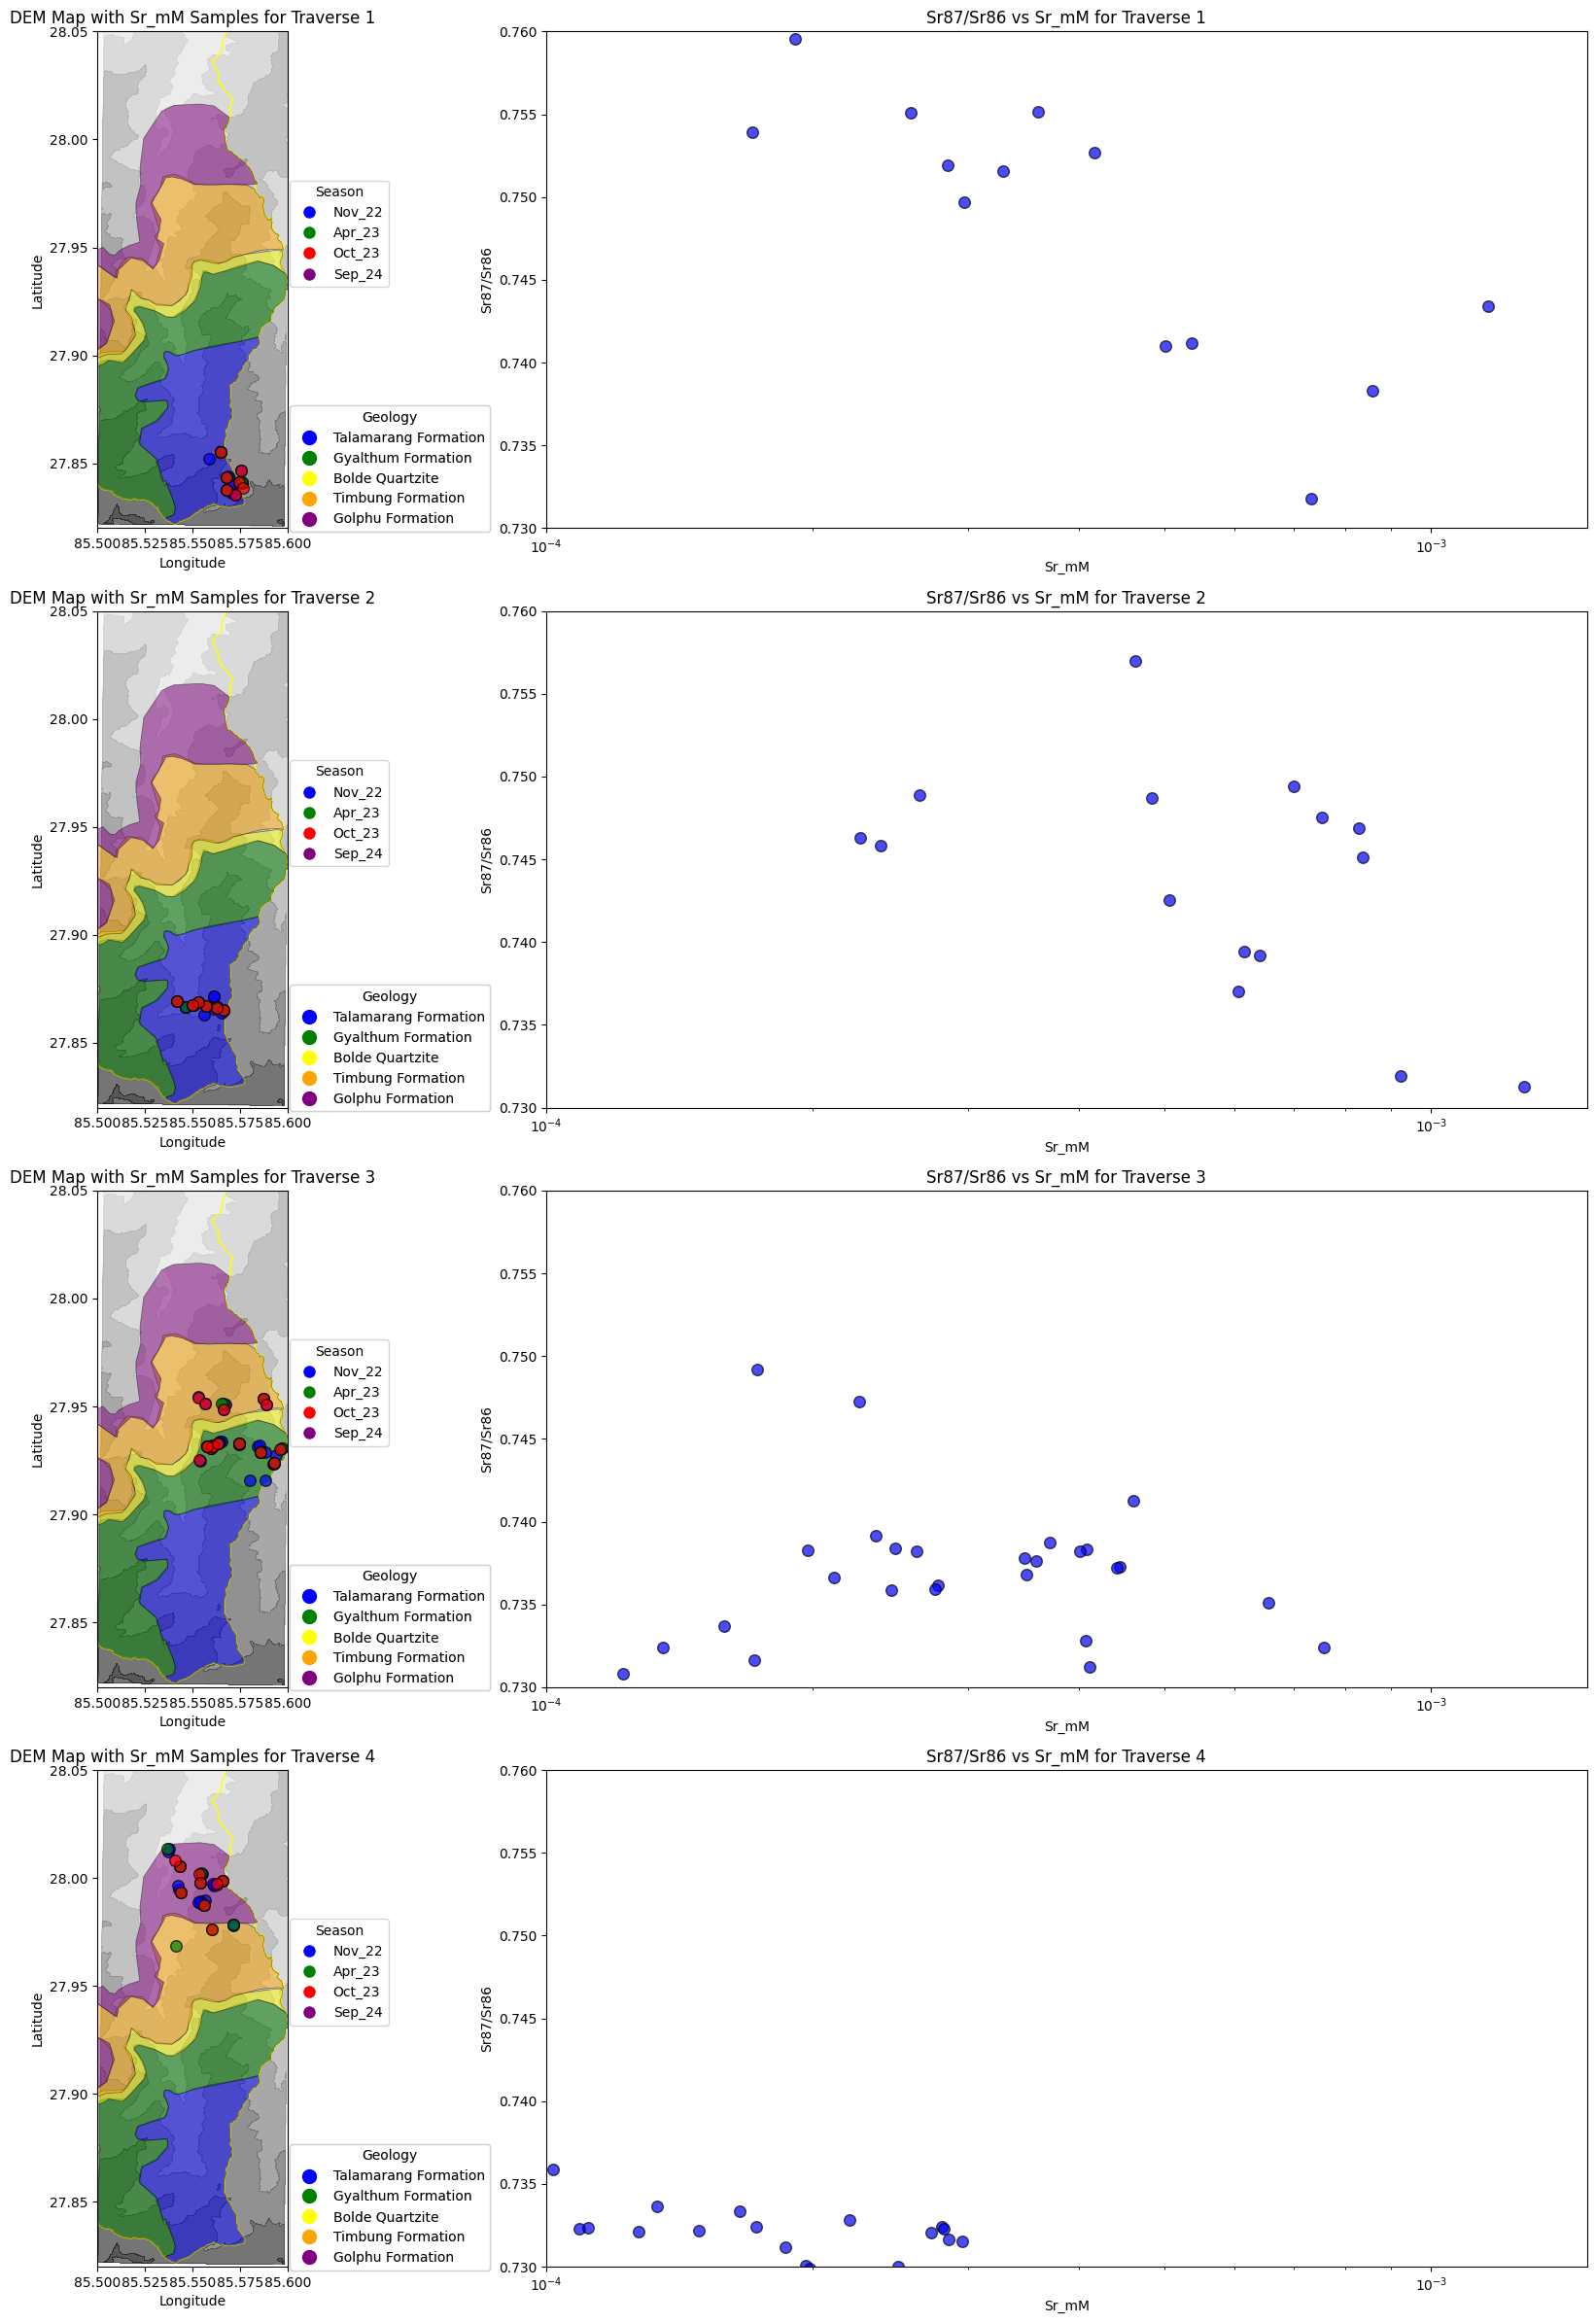

In [50]:
# Create the figure and axes for side-by-side plots
fig, axs = plt.subplots(4, 2, figsize=(20, 24))

# Define the variables and traverses
variables = ['Sr87/Sr86', 'Sr_mM']
tributaries = ['Traverse 1', 'Traverse 2', 'Traverse 3', 'Traverse 4']

GNS_markers = ['S1', 'S2', 'S3', 'S4']


# Loop over each traverse and corresponding axes
for i, traverse in enumerate(tributaries):
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]
    
    # Plot the DEM data in grayscale on ax1
    c = ax1.contourf(x, y, z, cmap='Greys', alpha=0.7)

    # Overlay the shapefile for watershed boundary
    gdf.plot(ax=ax1, facecolor='none', edgecolor='yellow', alpha=1, linewidth=1, label='Melamchi Watershed')
    
    # Overlay gdf2 on ax1 with specified colors and labels
    plotted_labels = set()  # Keeps track of which labels have been plotted
    geology_handles = []  # Handles for individual geology legend next to ax1
    for geom, id_value in zip(gdf2.geometry, gdf2['id']):
        color = id_to_color.get(id_value, 'grey')  # Default to grey if ID is not in the mapping
        label = id_to_label.get(id_value, '')
        
        if isinstance(geom, Polygon):
            x_poly, y_poly = geom.exterior.xy
            ax1.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)
            if label not in plotted_labels:
                plotted_labels.add(label)
                geology_handles.append(Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='None', label=label))
        elif isinstance(geom, MultiPolygon):
            for part in geom.geoms:
                x_poly, y_poly = part.exterior.xy
                ax1.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)
                if label not in plotted_labels:
                    plotted_labels.add(label)
                    geology_handles.append(Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='None', label=label))


    # Plot the points for each season and traverse
    traverse_data = df_copy[df_copy['Traverse'] == traverse]
    for season, color in season_colors.items():
        season_data = traverse_data[traverse_data['Season'] == season]
        ax1.scatter(
            season_data['Longitude'], season_data['Latitude'], 
            c=color, s=70, alpha=0.7, edgecolor='k', 
            marker=traverse_markers[traverse], label=f'{traverse} - {season}'
        )


    # Create a legend for the seasons in ax1
    season_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=season) 
        for season, color in season_colors.items()
    ]

    # Set map limits for ax1
    ax1.set_xlim(85.5, 85.6)
    ax1.set_ylim(27.82, 28.05)


    # Labels and title for ax1
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title(f'DEM Map with {variables[1]} Samples for {traverse}')
    season_legend = ax1.legend(handles=season_handles, title='Season', loc='upper left', bbox_to_anchor=(1.01, 0.7),
        borderaxespad=0.)

    # Place the geology legend to the right of ax1
    geology_legend = ax1.legend(
        handles=geology_handles, 
        title='Geology', 
        loc='center left', 
        bbox_to_anchor=(1.01, 0.12),
        borderaxespad=0.
    )

    # Add both legends to the plot
    ax1.add_artist(geology_legend)
    ax1.add_artist(season_legend)
    
    # Plotting data in ax2 (variable vs. elevation)
    for season, color in season_colors.items():
        season_data = traverse_data[traverse_data['Season'] == season]
        ax2.scatter(
            season_data[variables[1]], season_data[variables[0]], 
            c=color, s=70, alpha=0.7, edgecolor='k', 
            marker=traverse_markers[traverse], label=f'{traverse} - {season}'
        )

    ax2.set_xlabel(f'{variables[1]}')
    ax2.set_ylabel(f'{variables[0]}')
    ax2.set_xscale('log')
    ax2.set_ylim(0.73,0.76)
    ax2.set_xlim(0.0001,0.0015)
    ax2.set_title(f'{variables[0]} vs {variables[1]} for {traverse}')

# Adjust layout and save    
plt.tight_layout()
plt.savefig('Srisotopes-Sr.png', bbox_inches='tight')
plt.show()
plt.close(fig)

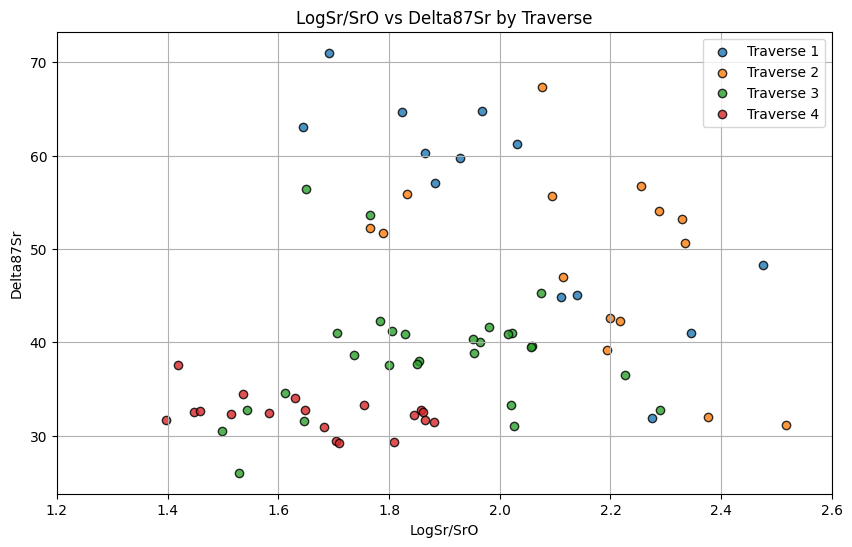

In [51]:
##Sr is gained as we go down the watershed. It would be wrong to say it was lost as we go up because Sr is consistently being added by rain
## But at the bottom where we have little contribution of rain there is scope for raleigh fractionation
#Log [C/Co]

SrMin = df_copy['Sr_mM'].min()

df_copy['LogSr/SrO'] = np.log10(df_copy['Sr_mM'] / SrMin)

#traverse_data = df_copy[df_copy['Traverse'] == 'Traverse 1']

traverse_data = df_copy
plt.figure(figsize=(10, 6))
for traverse, marker in traverse_markers.items():
    traverse_data = df_copy[df_copy['Traverse'] == traverse]
    plt.scatter(traverse_data['LogSr/SrO'], traverse_data['Delta87Sr'], label=traverse, alpha=0.8, edgecolor='k', marker=marker)

plt.xlabel('LogSr/SrO')
plt.ylabel('Delta87Sr')
plt.xlim(1.2, 2.6)
plt.title('LogSr/SrO vs Delta87Sr by Traverse')
plt.legend()
plt.grid(True)
plt.show()

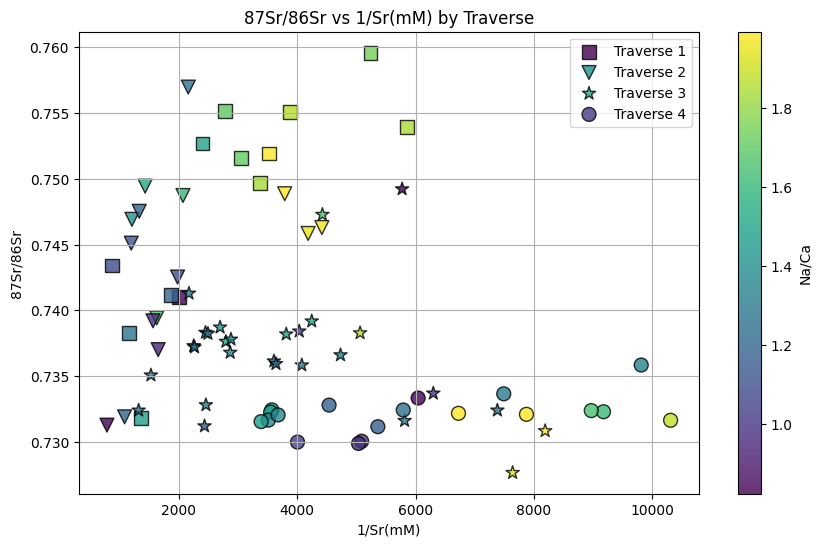

In [83]:
# Calculate 1/Sr(mM)
df_copy['1/Sr_mM'] = 1 / df_copy['Sr_mM']

# Plot 87Sr/86Sr against 1/Sr(mM)
plt.figure(figsize=(10, 6))
for traverse, marker in traverse_markers.items():
    traverse_data = df_copy[df_copy['Traverse'] == traverse]
    plt.scatter(traverse_data['1/Sr_mM'], traverse_data['Sr87/Sr86'], c=traverse_data['Na/Ca'], cmap='viridis', label=traverse, alpha=0.8, edgecolor='k', marker=marker, s=100)

plt.xlabel('1/Sr(mM)')
plt.ylabel('87Sr/86Sr')
plt.colorbar(label='Na/Ca')
plt.title('87Sr/86Sr vs 1/Sr(mM) by Traverse')
plt.legend()
plt.grid(True)
plt.show()

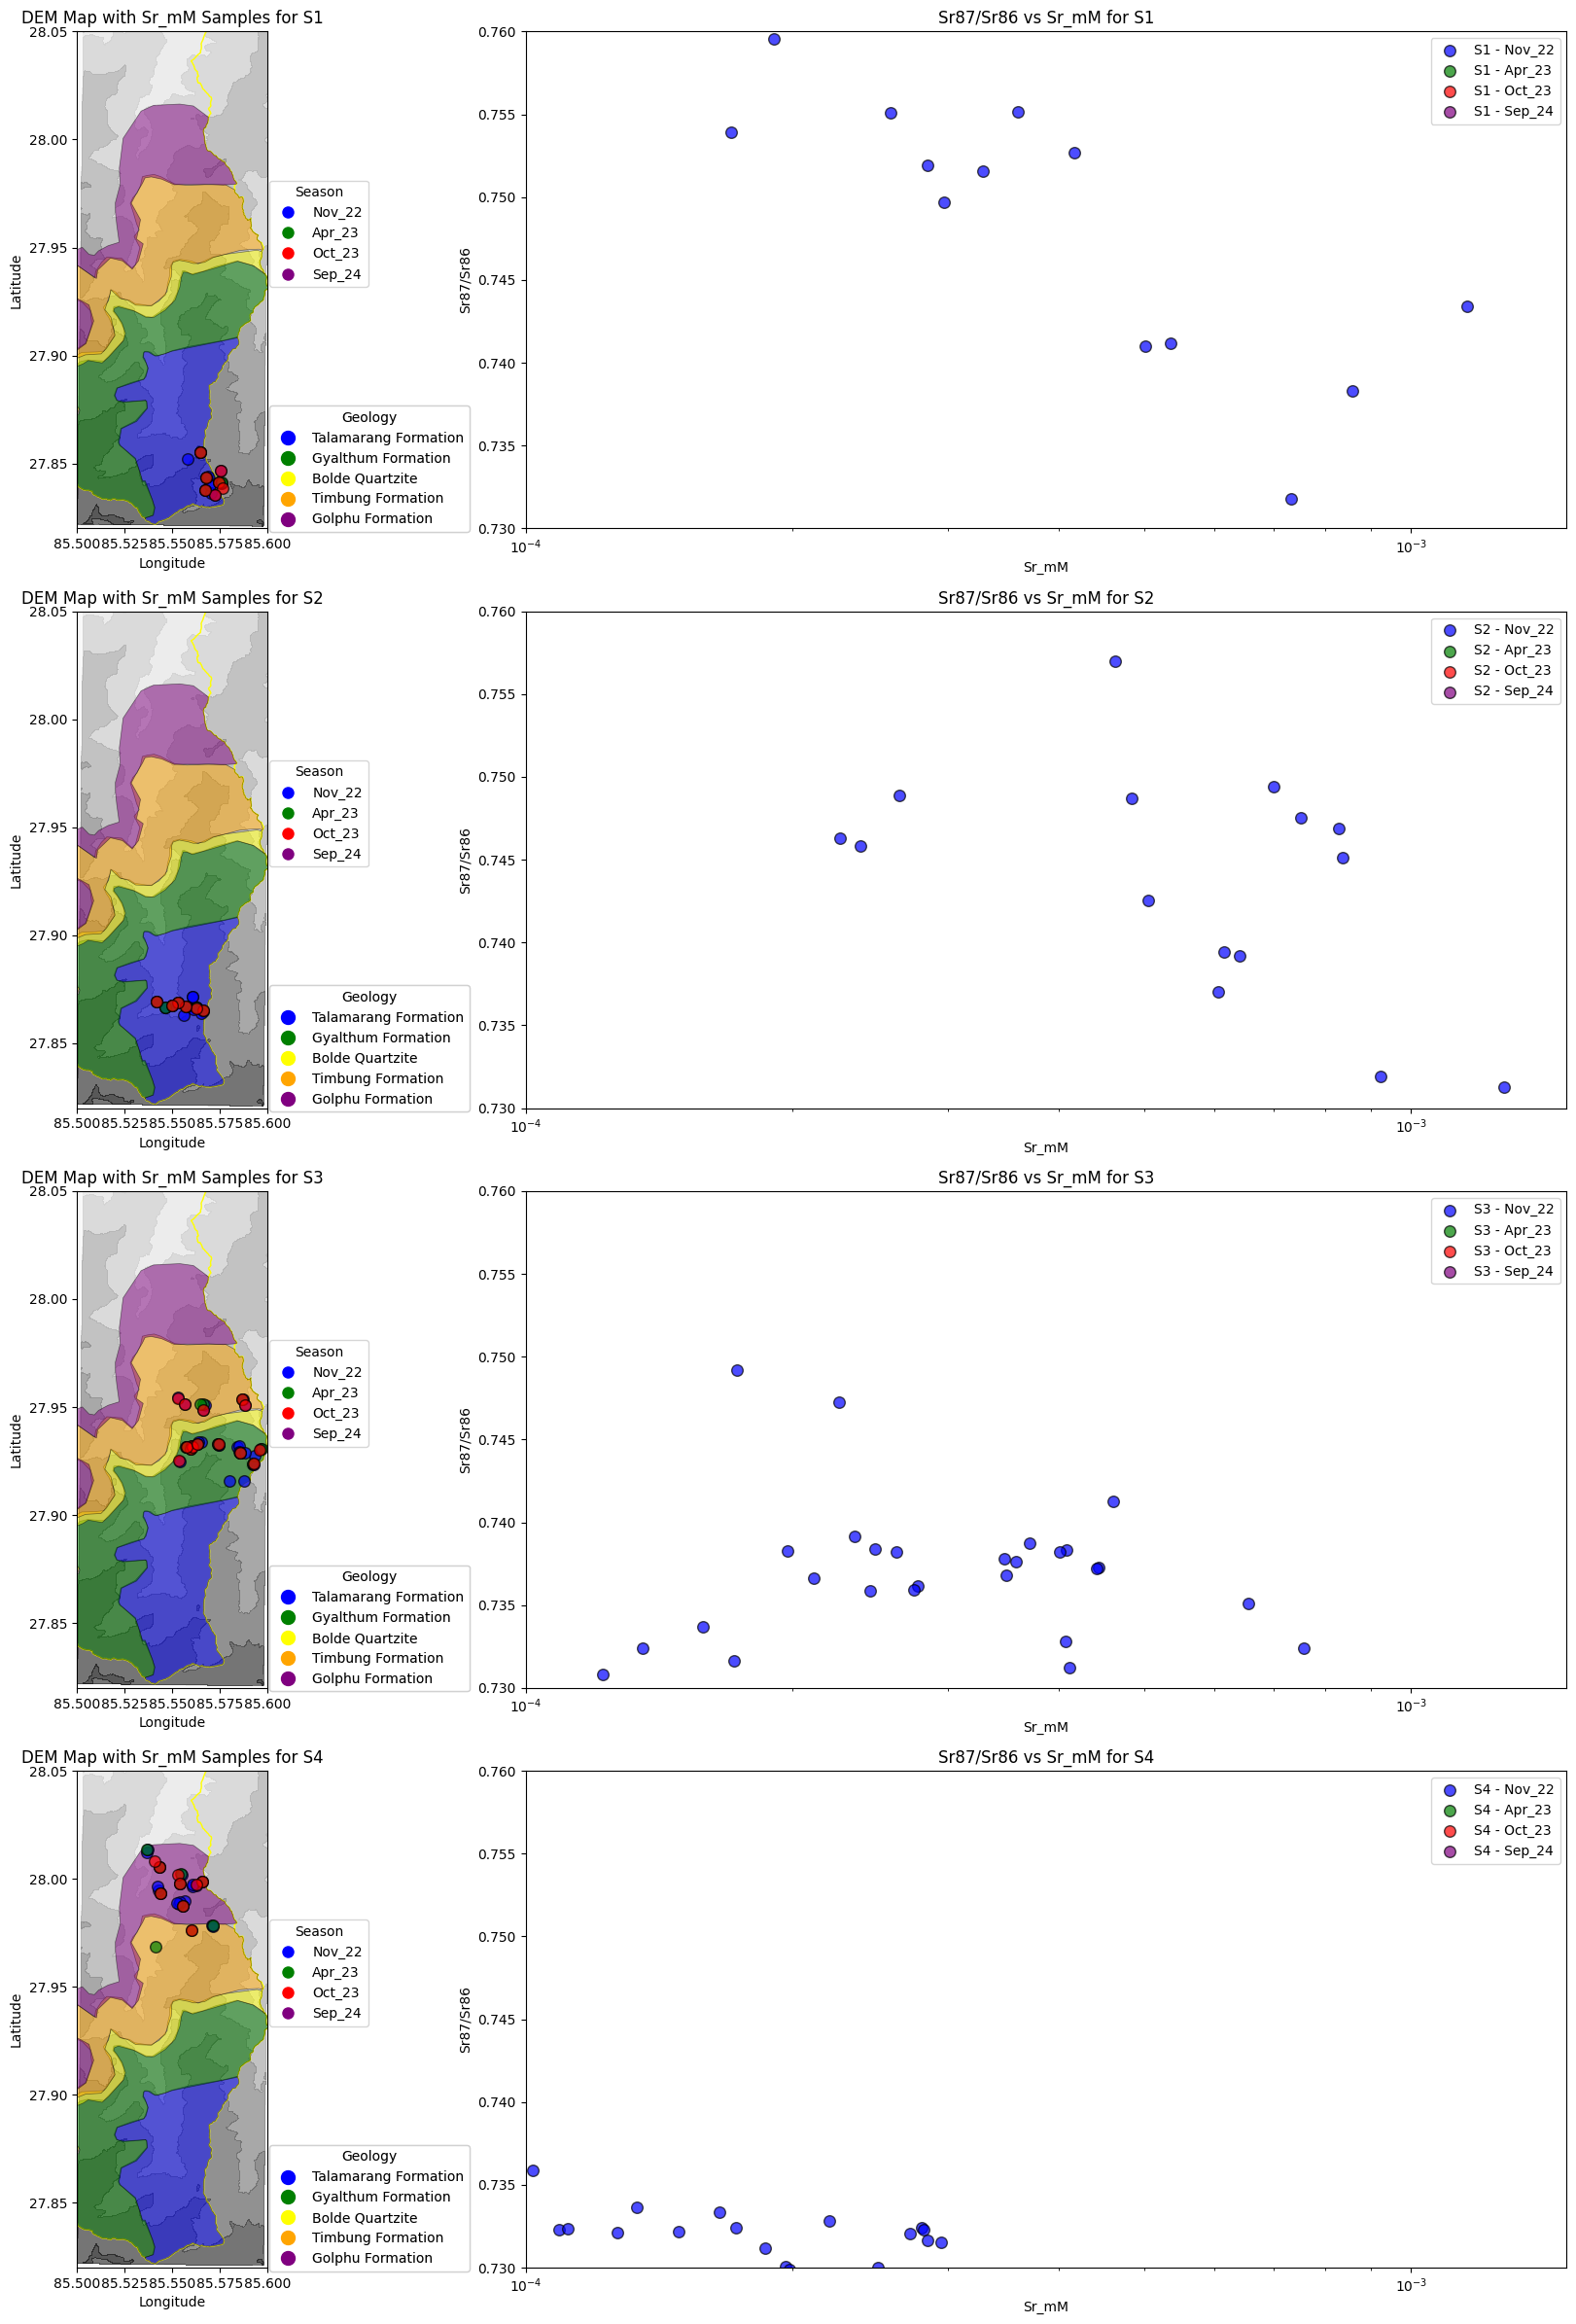

In [66]:
# Create the figure and axes for side-by-side plots
fig, axs = plt.subplots(4, 2, figsize=(20, 24))

# Define the variables and traverses
variables = ['Sr87/Sr86', 'Sr_mM']

#variables = ['d88Sr', 'Sr_mM']

tributaries = ['Traverse 1', 'Traverse 2', 'Traverse 3', 'Traverse 4']

GNS_markers = ['S1', 'S2', 'S3', 'S4']


# Loop over each traverse and corresponding axes
for i, gns in enumerate(GNS_markers):
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]
    
    # Plot the DEM data in grayscale on ax1
    c = ax1.contourf(x, y, z, cmap='Greys', alpha=0.7)

    # Overlay the shapefile for watershed boundary
    gdf.plot(ax=ax1, facecolor='none', edgecolor='yellow', alpha=1, linewidth=1, label='Melamchi Watershed')
    
    # Overlay gdf2 on ax1 with specified colors and labels
    plotted_labels = set()  # Keeps track of which labels have been plotted
    geology_handles = []  # Handles for individual geology legend next to ax1
    for geom, id_value in zip(gdf2.geometry, gdf2['id']):
        color = id_to_color.get(id_value, 'grey')  # Default to grey if ID is not in the mapping
        label = id_to_label.get(id_value, '')
        
        if isinstance(geom, Polygon):
            x_poly, y_poly = geom.exterior.xy
            ax1.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)
            if label not in plotted_labels:
                plotted_labels.add(label)
                geology_handles.append(Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='None', label=label))
        elif isinstance(geom, MultiPolygon):
            for part in geom.geoms:
                x_poly, y_poly = part.exterior.xy
                ax1.fill(x_poly, y_poly, color=color, alpha=0.5, edgecolor='black', linewidth=0.5)
                if label not in plotted_labels:
                    plotted_labels.add(label)
                    geology_handles.append(Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='None', label=label))


    # Plot the points for each season and traverse
    # Handle potential NaN values in 'GNS' by filling them with an empty string
    traverse_data = df_copy[df_copy['GNS'].fillna('').str.startswith(gns)]

    GNS_markers = {
        'S1': 'o',
        'S2': 'o',
        'S3': 'o',
        'S4': 'o'
    }

    for season, color in season_colors.items():
        season_data = traverse_data[traverse_data['Season'] == season]
        ax1.scatter(
            season_data['Longitude'], season_data['Latitude'], 
            c=color, s=70, alpha=0.7, edgecolor='k', 
            marker=GNS_markers.get(gns, 'o'), label=f'{gns} - {season}'
        )


    # Create a legend for the seasons in ax1
    season_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=season) 
        for season, color in season_colors.items()
    ]

    # Set map limits for ax1
    ax1.set_xlim(85.5, 85.6)
    ax1.set_ylim(27.82, 28.05)


    # Labels and title for ax1
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title(f'DEM Map with {variables[1]} Samples for {gns}')
    season_legend = ax1.legend(handles=season_handles, title='Season', loc='upper left', bbox_to_anchor=(1.01, 0.7),
        borderaxespad=0.)

    # Place the geology legend to the right of ax1
    geology_legend = ax1.legend(
        handles=geology_handles, 
        title='Geology', 
        loc='center left', 
        bbox_to_anchor=(1.01, 0.12),
        borderaxespad=0.
    )

    # Add both legends to the plot
    ax1.add_artist(geology_legend)
    ax1.add_artist(season_legend)
    
    # Plotting data in ax2 (variable vs. elevation)
    for season, color in season_colors.items():
        season_data = traverse_data[traverse_data['Season'] == season]
        ax2.scatter(
            season_data[variables[1]], season_data[variables[0]], 
            c=color, s=70, alpha=0.7, edgecolor='k', 
            marker=GNS_markers[gns], label=f'{gns} - {season}'
        )


    ax2.legend()
    ax2.set_xlabel(f'{variables[1]}')
    ax2.set_ylabel(f'{variables[0]}')
    ax2.set_xscale('log')
    ax2.set_ylim(0.73,0.76)
    ax2.set_xlim(0.0001,0.0015)
    ax2.set_title(f'{variables[0]} vs {variables[1]} for {gns}')

# Adjust layout and save    
plt.tight_layout()
plt.savefig('Srisotopes-Sr.png', bbox_inches='tight')
plt.show()
plt.close(fig)

/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_56984/285436592.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


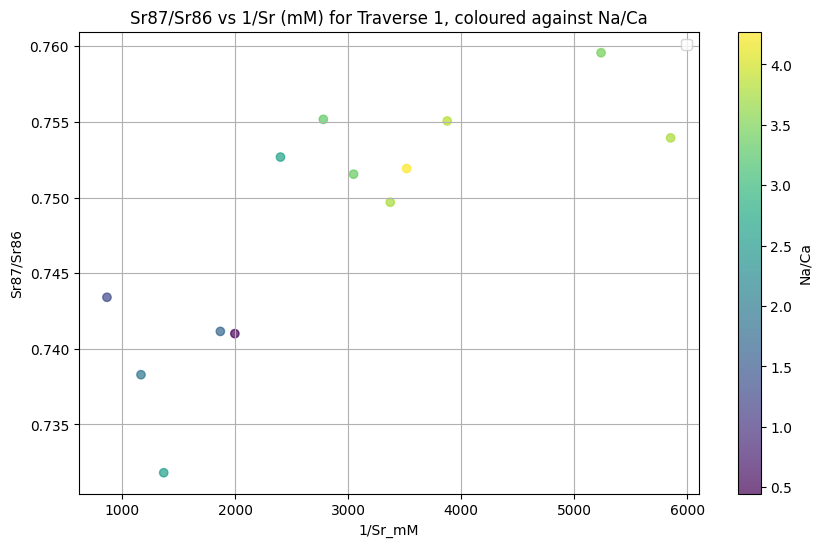

In [79]:


# Filter the DataFrame for samples whose GNS starts with 'S'
filtered_df = df_copy[df_copy['GNS'].str.startswith('S1', na=False)]

# remove samples with Ca/Na greater than 2
#filtered_df = filtered_df[filtered_df['Ca/Na'] < 2]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['1/Sr_mM'], filtered_df['Sr87/Sr86'], c=filtered_df['Na/Ca'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Na/Ca')
#plt.xscale('log')
plt.xlabel('1/Sr_mM')
plt.ylabel('Sr87/Sr86')
plt.title('Sr87/Sr86 vs 1/Sr (mM) for Traverse 1, coloured against Na/Ca')
plt.legend()
plt.grid(True)
plt.show()

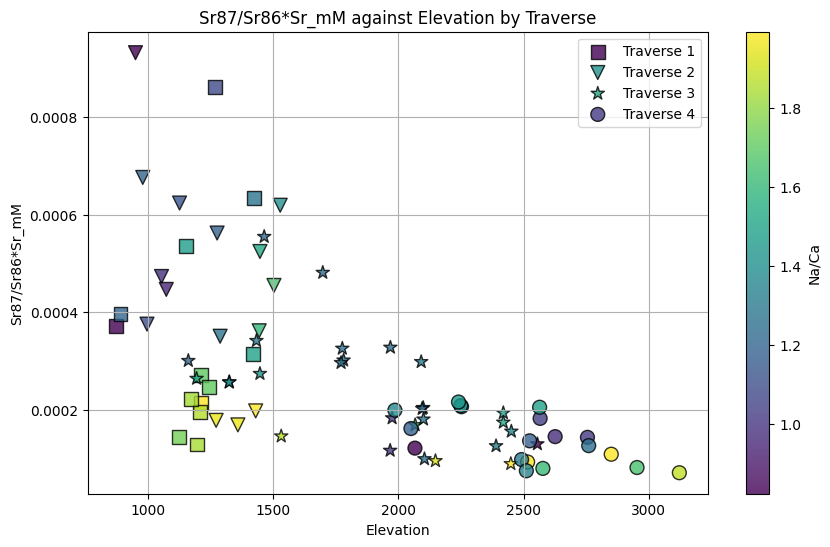

In [86]:
# Calculate 1/Sr(mM)
df_copy['1/Sr_mM'] = 1 / df_copy['Sr_mM']

df_copy['Sr87/Sr86*Sr_mM'] = df_copy['Sr87/Sr86'] * df_copy['Sr_mM']


# Plot 87Sr/86Sr against 1/Sr(mM)
plt.figure(figsize=(10, 6))
for traverse, marker in traverse_markers.items():
    traverse_data = df_copy[df_copy['Traverse'] == traverse]
    plt.scatter(traverse_data['Elevation'], traverse_data['Sr87/Sr86*Sr_mM'], c=traverse_data['Na/Ca'], cmap='viridis', label=traverse, alpha=0.8, edgecolor='k', marker=marker, s=100)

plt.xlabel('Elevation')
plt.ylabel('Sr87/Sr86*Sr_mM')
plt.colorbar(label='Na/Ca')
plt.title('Sr87/Sr86*Sr_mM against Elevation by Traverse')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_56984/2182820496.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traverse_data['Elevation'], traverse_data['Na/Ca'], cmap='viridis', label=traverse, alpha=0.8, edgecolor='k', marker=marker, s=100)


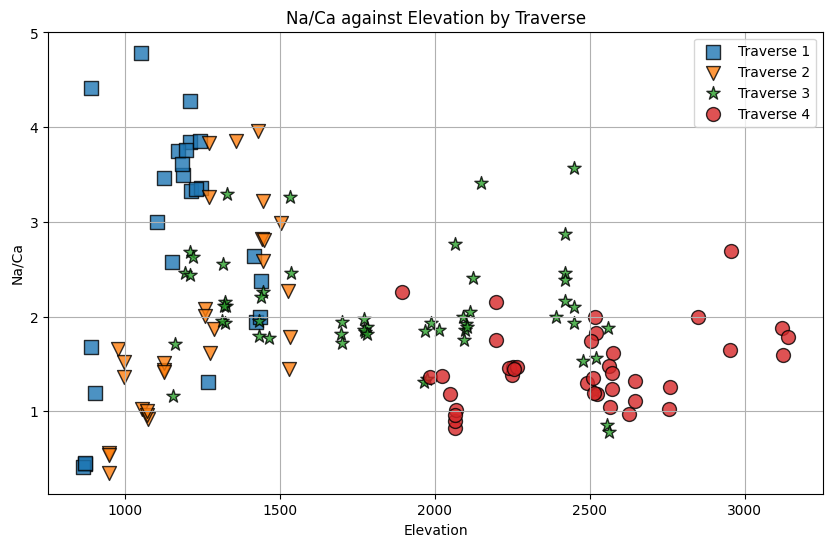

In [87]:

plt.figure(figsize=(10, 6))
for traverse, marker in traverse_markers.items():
    traverse_data = df_copy[df_copy['Traverse'] == traverse]
    plt.scatter(traverse_data['Elevation'], traverse_data['Na/Ca'], cmap='viridis', label=traverse, alpha=0.8, edgecolor='k', marker=marker, s=100)

plt.xlabel('Elevation')
plt.ylabel('Na/Ca')
plt.title('Na/Ca against Elevation by Traverse')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
from geopy.distance import geodesic

# Assuming df_copy is your DataFrame with 'Latitude' and 'Longitude' columns
ridge_longitude = 86.62  # Longitude of the ridge crest

# Function to calculate horizontal distance from the ridge crest at the same latitude
def calculate_ridge_distance(lat, lon):
    # The reference point at the same latitude as the given point, with the ridge longitude
    reference_point = (lat, ridge_longitude)
    point = (lat, lon)  # Using the same latitude but varying the longitude
    distance = geodesic(reference_point, point).kilometers
    return distance

# Apply the function to each row and add 'ridge distance' column to df_copy
df_copy['ridge distance'] = df_copy.apply(lambda row: calculate_ridge_distance(row['Latitude'], row['Longitude']), axis=1)
